In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Step 1. Measure the Determinants of Confidence Including Crime Outcomes

In [30]:
outcome_df = pd.read_csv('C:/Users/20220678/Microsoft VS Code/JBG050-DC2-GRP21/data/curated_data/outcome.csv')

print(outcome_df['Outcome type'].unique())

['Investigation complete; no suspect identified' 'Local resolution'
 'Suspect charged' 'Offender given penalty notice'
 'Offender given a caution' 'Offender given a drugs possession warning'
 'Suspect charged as part of another case'
 'Formal action is not in the public interest'
 'Unable to prosecute suspect']


In [31]:
def categorize_outcome(outcome):
    successful_outcomes = [
        'Suspect charged', 
        'Offender given penalty notice',
        'Offender given a caution', 
        'Offender given a drugs possession warning',
        'Suspect charged as part of another case'
    ]
    unsuccessful_outcomes = [
        'Investigation complete; no suspect identified', 
        'Formal action is not in the public interest',
        'Unable to prosecute suspect'
    ]
    
    if outcome in successful_outcomes:
        return "Successful"
    elif outcome in unsuccessful_outcomes:
        return "Unsuccessful"
    else:
        return "Other"

outcome_df['Intervention_Success'] = outcome_df['Outcome type'].apply(categorize_outcome)

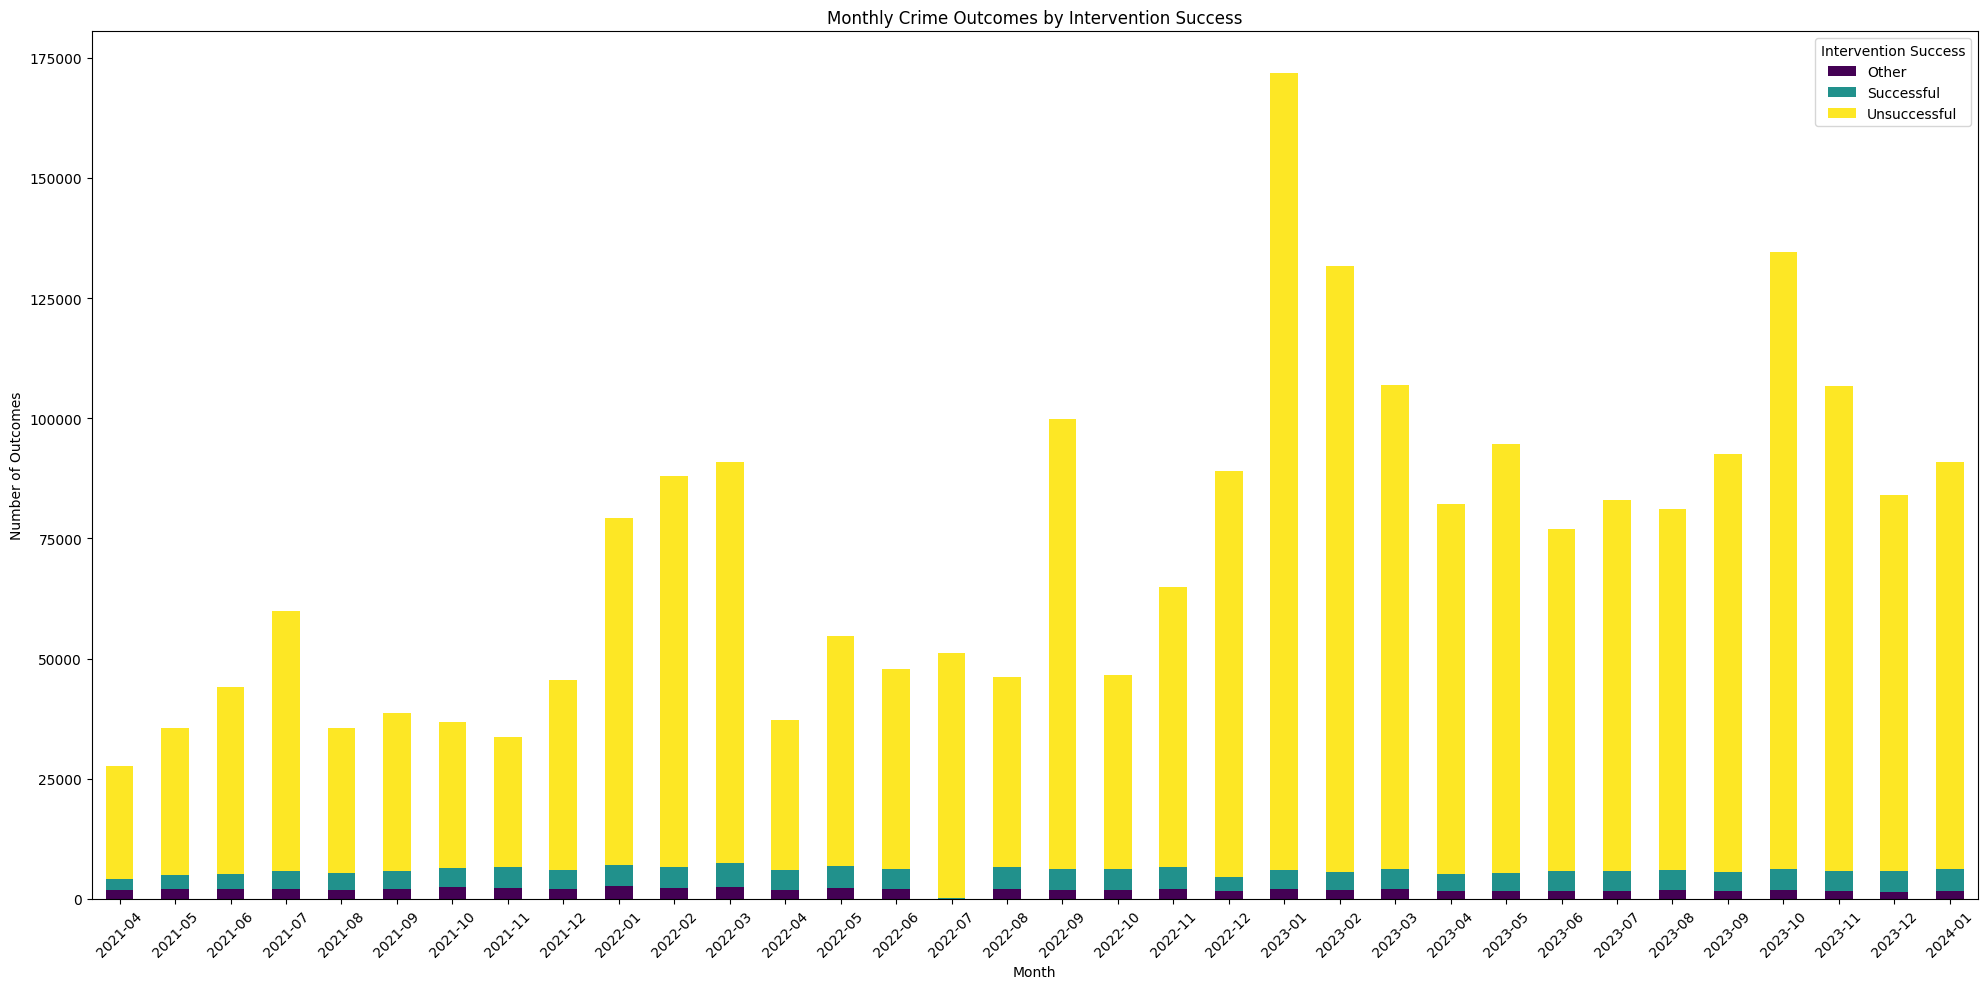

In [32]:
monthly_outcomes = outcome_df.groupby(['Month', 'Intervention_Success']).size().unstack(fill_value=0)

monthly_outcomes.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='viridis')
plt.title('Monthly Crime Outcomes by Intervention Success')
plt.xlabel('Month')
plt.ylabel('Number of Outcomes')
plt.xticks(rotation=45)
plt.legend(title='Intervention Success')
plt.tight_layout()
plt.show()

Step 2. Data Preparation

In [76]:
# Mapping function

label_to_value_map = {
    '1 Not at all well': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7 Very well': 7,
    "Don't know": 97,
    'Refused': 98,
    'Not Asked': 99,

    'Strongly agree': 5,
    'Tend to agree': 4,
    'Neither agree nor disagree': 3,
    'Tend to disagree': 2,
    'Strongly disagree': 1,
    

    'Yes': 2,
    'No': 1,

    'Very confident': 4,
    'Fairly confident': 3,
    'Not very confident': 2,
    'Not at all confident': 1,

    'At least daily': 6,
    'At least weekly': 5,
    'At least fortnightly': 4,
    'At least monthly': 3,
    'Less often': 2,
    'Never': 1,

    'Very safe': 6,
    'Fairly safe': 5,
    'Fairly unsafe': 4,
    'Very unsafe': 2,
    '(spontaneous) Do not go out at all': 1,
    '(spontaneous) Do not go out alone': 3,

    'Very well informed': 3,
    'Fairly well informed': 2,
    'Not at all informed': 1
}

def label_to_value(label):
    return label_to_value_map.get(label, label)  # Return the label itself if not found in the map


In [102]:
files = [
    "data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv",
    "data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv"
]

all_data = pd.DataFrame()

survey_columns = [
    'MONTH', 'C2',
    'Q79I', 'Q79B', 'Q79D', 'Q79E',  # Effectiveness
    'Q62B', 'Q62C', 'A121',  # Fairness and engagement
    'NQ135BH',  # Accountability
    'Q65', 'Q21', 'Q131'  # Confidence
]


dataframes = []
for file in files:
    try:

        df = pd.read_csv(file)
        
        cols_to_select = [col for col in survey_columns if col in df.columns]
        selected_df = df[cols_to_select]
        
        dataframes.append(selected_df)
        print(f"Loaded {file} with selected columns.")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine all the dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

C:\Users\20220678\AppData\Local\Temp\ipykernel_23908\396862873.py:23: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,35,177,410,411,412,415,416,417,418,419,420,421,422,423) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loaded data/pas_data_ward_level/PAS_ward_level_FY_15_17.csv with selected columns.


C:\Users\20220678\AppData\Local\Temp\ipykernel_23908\396862873.py:23: DtypeWarning: Columns (30,31,32,98,99,100,101,102,103,104,105,125,126,127,199,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loaded data/pas_data_ward_level/PAS_ward_level_FY_17_18.csv with selected columns.


C:\Users\20220678\AppData\Local\Temp\ipykernel_23908\396862873.py:23: DtypeWarning: Columns (25,26,27,28,108,109,110,112,113,137,202,203,381) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loaded data/pas_data_ward_level/PAS_ward_level_FY_18_19.csv with selected columns.


C:\Users\20220678\AppData\Local\Temp\ipykernel_23908\396862873.py:23: DtypeWarning: Columns (41,42,43,131,132,133,213,214,435,444,451) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loaded data/pas_data_ward_level/PAS_ward_level_FY_19_20.csv with selected columns.


In [103]:
# Do the mapping
for column in combined_df.columns:
    combined_df[column] = combined_df[column].apply(label_to_value)

In [106]:
def scale_0_1(value, min_val, max_val):
    if value in [97, 98, 99]:  # Did't consider 'Don't know', 'Refused', 'Not Asked' WE MUST INTERFERE HERE
        return None
    if pd.isna(value):
        return None
    return (value - min_val) / (max_val - min_val)

max_values = {
    'Q79I': 7, 'Q79B': 7, 'Q79D': 7, 'Q79E': 7,
    'Q62B': 5, 'Q62C': 5, 'A121': 4,
    'NQ135BH': 5,
    'Q65': 6, 'Q21': 6, 'Q131': 3
}

for column in max_values:
    if column in combined_df.columns:
        combined_df[column] = combined_df[column].apply(lambda x: scale_0_1(x, 1, max_values[column]))

In [107]:
grouped = combined_df.groupby(['MONTH', 'C2']).median().reset_index()

effectiveness_questions = ['Q79I', 'Q79B', 'Q79D', 'Q79E']
fairness_engagement_questions = ['Q62B', 'Q62C', 'A121']
accountability_questions = ['NQ135BH']
confidence_questions = ['Q65', 'Q21', 'Q131']

# MAKE SURE MEAN IS CORRECT
grouped['Effectiveness'] = grouped[effectiveness_questions].mean(axis=1)
grouped['Fairness and Engagement'] = grouped[fairness_engagement_questions].mean(axis=1)
grouped['Accountability'] = grouped[accountability_questions].mean(axis=1)
grouped['Confidence Questions'] = grouped[confidence_questions].mean(axis=1)

# Calculate 'Trust' as the mean of the first three categories
grouped['Trust'] = grouped[['Effectiveness', 'Fairness and Engagement', 'Accountability']].mean(axis=1)

# Update 'Confidence' to be the mean of itself and 'Trust'
grouped['Confidence'] = grouped[['Confidence Questions', 'Trust']].mean(axis=1)

In [108]:
# Change the format of the month
grouped['Date'] = pd.to_datetime(grouped['MONTH'].str.extract(r'\((.*?)\)')[0], format='%b %Y')
grouped.sort_values('Date', inplace=True)
grouped['MONTH'] = grouped['Date'].dt.strftime('%b %Y')

In [110]:
grouped.head()

,MONTH,C2,Q79I,Q79B,Q79D,Q79E,Q62B,Q62C,A121,NQ135BH,Q65,Q21,Q131,Effectiveness,Fairness and Engagement,Accountability,Confidence Questions,Trust,Confidence,Date
310,Apr 2015,Merton,NaN,0.666667,0.500000,0.500000,0.75,0.75,0.666667,NaN,0.4,0.8,0.0,0.555556,0.722222,NaN,0.400000,0.638889,0.519444,2015-04-01
319,Apr 2015,Westminster,NaN,0.666667,0.750000,0.666667,0.75,0.75,0.666667,NaN,0.8,0.8,0.5,0.694444,0.722222,NaN,0.700000,0.708333,0.704167,2015-04-01
318,Apr 2015,Wandsworth,NaN,0.666667,0.666667,0.666667,0.75,0.75,0.333333,NaN,0.2,0.8,0.0,0.666667,0.611111,NaN,0.333333,0.638889,0.486111,2015-04-01
317,Apr 2015,Waltham Forest,NaN,0.833333,0.666667,0.666667,0.75,0.75,0.666667,NaN,0.8,0.8,0.5,0.722222,0.722222,NaN,0.700000,0.722222,0.711111,2015-04-01
316,Apr 2015,Tower Hamlets,NaN,0.666667,0.666667,0.666667,1.00,0.75,0.666667,NaN,0.4,0.8,0.5,0.666667,0.805556,NaN,0.566667,0.736111,0.651389,2015-04-01


Step 3. Preparation of final DataFrame

In [99]:
# MAKE SURE MEAN IS CORRECT
final_grouped = grouped.groupby(['MONTH', 'C2']).mean().reset_index()

In [100]:
final_grouped.head()

,MONTH,C2,Q79I,Q79B,Q79D,Q79E,Q62B,Q62C,A121,NQ135BH,Q65,Q21,Q131,Effectiveness,Fairness and Engagement,Accountability,Confidence Questions,Trust,Confidence,Date
0,Apr 2015,Barking and Dagenham,99.0,5.0,5.0,5.0,4.0,4.0,3.0,99.0,2.0,4.0,2.0,28.5,3.666667,99.0,2.666667,43.722222,23.194444,2015-04-01
1,Apr 2015,Barnet,99.0,5.0,5.0,5.0,4.5,4.0,3.0,99.0,2.0,5.0,2.0,28.5,3.833333,99.0,3.000000,43.777778,23.388889,2015-04-01
2,Apr 2015,Bexley,99.0,5.0,5.0,5.0,4.0,4.0,3.0,99.0,3.0,5.0,2.0,28.5,3.666667,99.0,3.333333,43.722222,23.527778,2015-04-01
3,Apr 2015,Brent,99.0,5.0,5.0,5.0,4.0,4.0,3.0,99.0,3.5,5.0,1.0,28.5,3.666667,99.0,3.166667,43.722222,23.444444,2015-04-01
4,Apr 2015,Bromley,99.0,5.0,5.0,5.0,4.0,4.0,3.0,99.0,4.0,5.0,2.0,28.5,3.666667,99.0,3.666667,43.722222,23.694444,2015-04-01


In [84]:
# WHY IS THERE ONE THAT HAS HIGHER THAN 1 ????????????????????
max_trust_per_borough = final_grouped.groupby('C2')['Trust'].max()
print("Maximum Trust values per Borough:")
print(max_trust_per_borough)


Maximum Trust values per Borough:
C2
Barking and Dagenham      0.944444
Barnet                    0.888889
Bexley                    0.937500
Brent                     0.888889
Bromley                   0.902778
Camden                    0.791667
Croydon                   0.819444
Ealing                    0.851852
Enfield                   0.754630
Greenwich                 0.865741
Hackney                   0.865741
Hammersmith and Fulham    0.909722
Haringey                  0.796296
Harrow                    0.807870
Havering                  0.912037
Hillingdon                0.858796
Hounslow                  0.916667
Islington                 0.861111
Kensington and Chelsea    0.907407
Kingston upon Thames      0.810185
Lambeth                   0.787037
Lewisham                  0.909722
Merton                    0.805556
Newham                    0.944444
Redbridge                 0.916667
Richmond upon Thames      0.791667
Southwark                 0.916667
Sutton            

C:\Users\20220678\AppData\Local\Temp\ipykernel_23908\1965509579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  borough_data['MONTH'] = pd.to_datetime(borough_data['MONTH'], format='%b %Y')
C:\Users\20220678\AppData\Local\Temp\ipykernel_23908\1965509579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  borough_data.sort_values('MONTH', inplace=True)


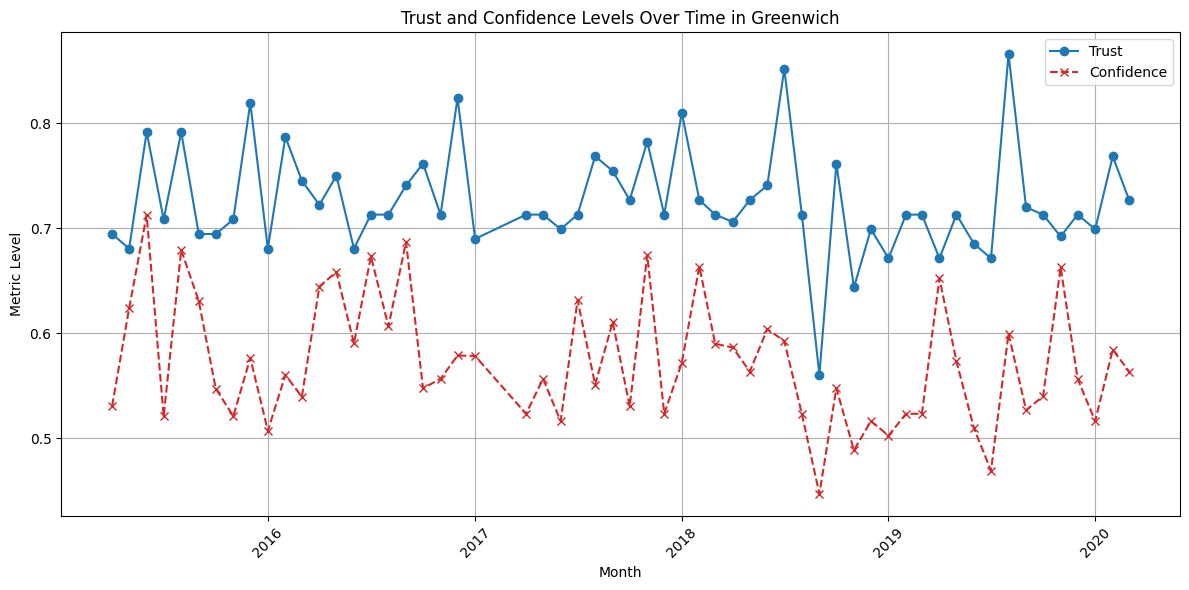

In [85]:
borough_data = final_grouped[final_grouped['C2'] == 'Greenwich']
borough_data['MONTH'] = pd.to_datetime(borough_data['MONTH'], format='%b %Y')
borough_data.sort_values('MONTH', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(borough_data['MONTH'], borough_data['Trust'], color='tab:blue', marker='o', linestyle='-', label='Trust')
plt.plot(borough_data['MONTH'], borough_data['Confidence'], color='tab:red', marker='x', linestyle='--', label='Confidence')

plt.title('Trust and Confidence Levels Over Time in Greenwich')
plt.xlabel('Month')
plt.ylabel('Metric Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\20220678\AppData\Local\Temp\ipykernel_23908\3686596468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camden_data['MONTH'] = pd.to_datetime(camden_data['MONTH'], format='%b %Y')


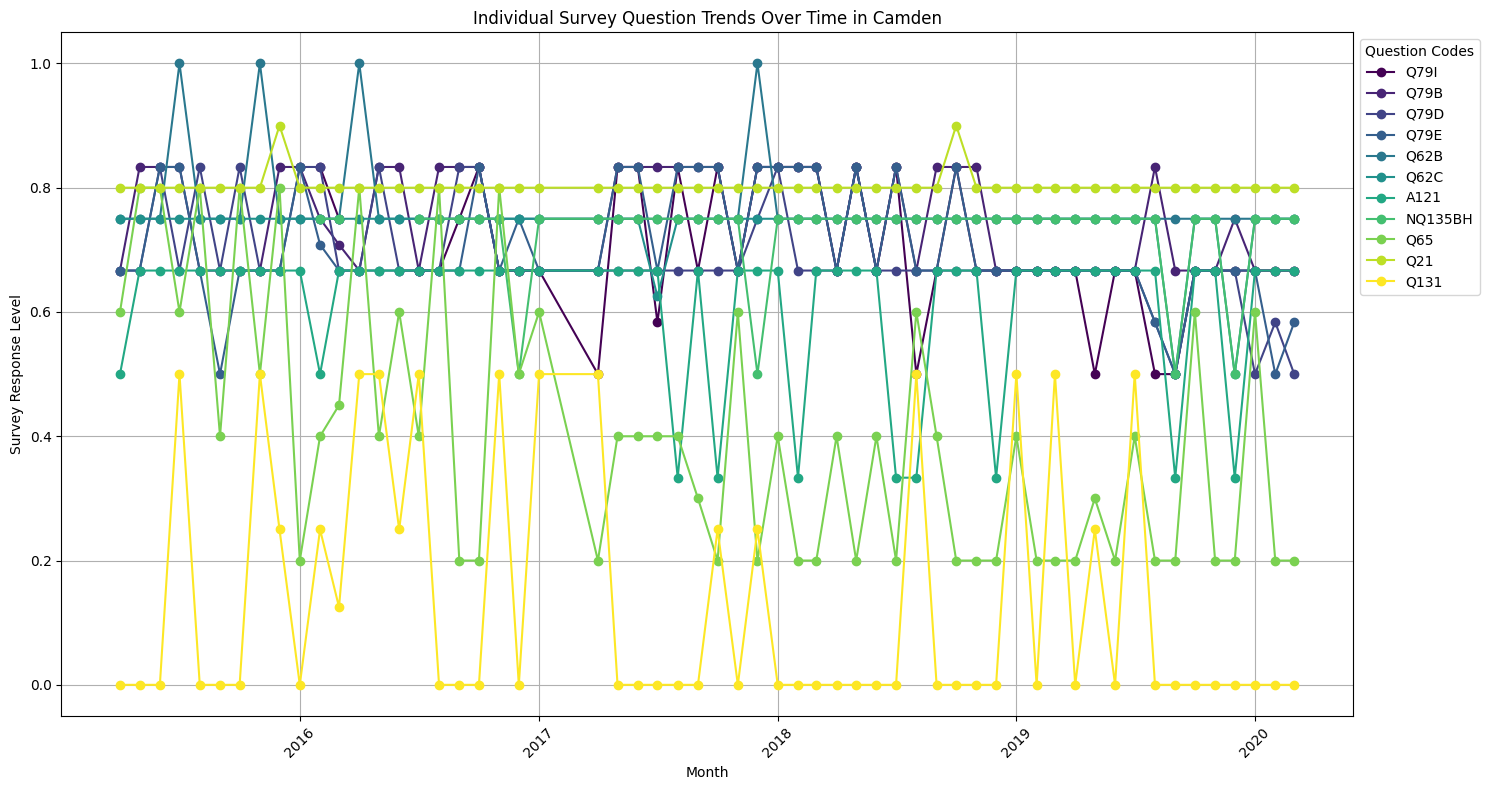

In [86]:
camden_data = final_grouped[final_grouped['C2'] == 'Camden']
camden_data['MONTH'] = pd.to_datetime(camden_data['MONTH'], format='%b %Y')
camden_data = camden_data.sort_values('MONTH')

question_columns = ['Q79I', 'Q79B', 'Q79D', 'Q79E', 'Q62B', 'Q62C', 'A121', 'NQ135BH', 'Q65', 'Q21', 'Q131']

# Q79D has an issue

plt.figure(figsize=(15, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(question_columns)))
for i, col in enumerate(question_columns):
    plt.plot(camden_data['MONTH'], camden_data[col], label=col, color=colors[i], marker='o', linestyle='-')

plt.title('Individual Survey Question Trends Over Time in Camden')
plt.xlabel('Month')
plt.ylabel('Survey Response Level')
plt.legend(title='Question Codes', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [126]:
PAS_file_path = "C:/Users/20220678/Microsoft VS Code/JBG050-DC2-Grp21/data/PAS_T&Cdashboard_to Q3 23-24.xlsx"
df_PAS = pd.read_excel(PAS_file_path, sheet_name='Borough')

trust_data = df_PAS[df_PAS['Measure'] == 'Trust MPS']

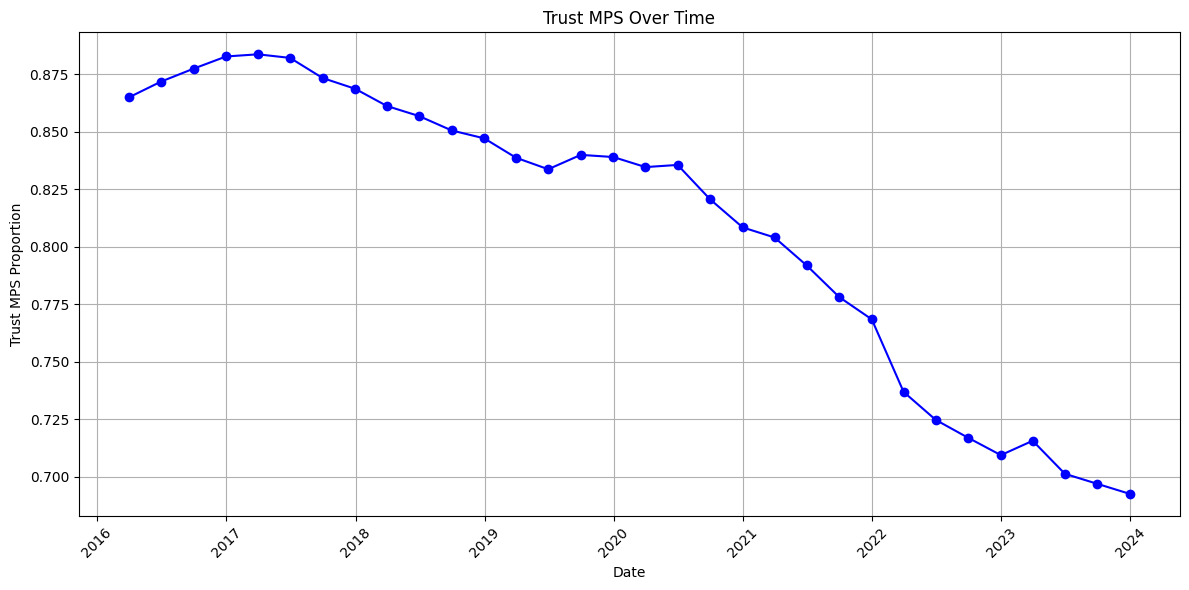

In [124]:
trust_mps_over_time = trust_data.groupby('Date')['Proportion'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(trust_mps_over_time['Date'], trust_mps_over_time['Proportion'], marker='o', linestyle='-', color='blue')
plt.title('Trust MPS Over Time')
plt.xlabel('Date')
plt.ylabel('Trust MPS Proportion')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

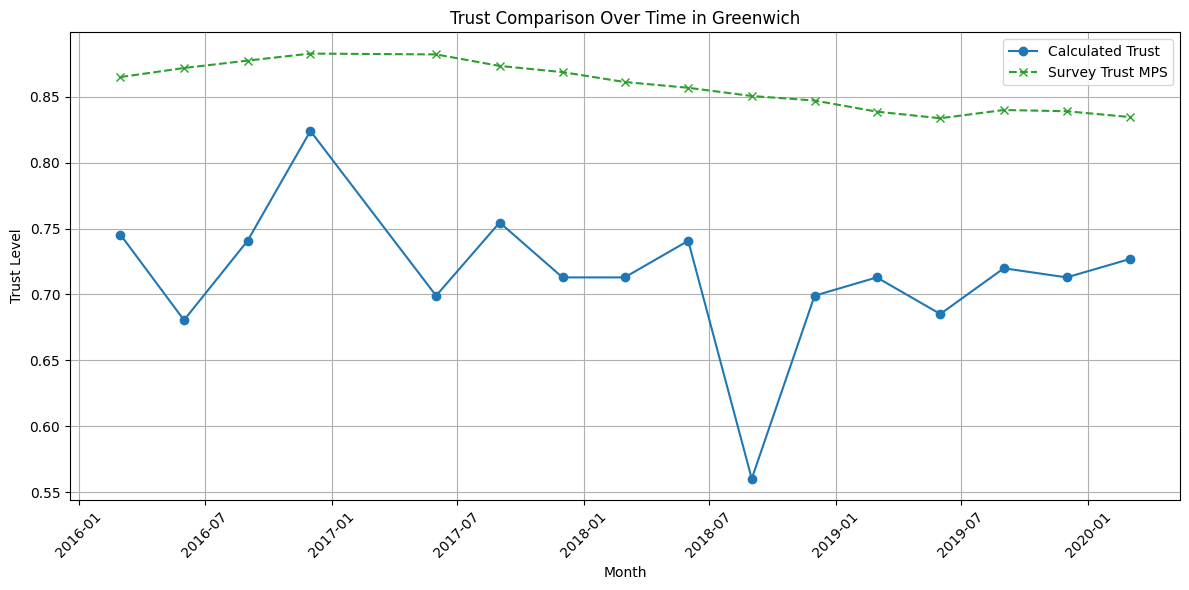

In [127]:
trust_mps_over_time['Date'] = pd.to_datetime(trust_mps_over_time['Date'], dayfirst=True)

# Change the Date to the start of the month to match with 'MONTH' in final_grouped
trust_mps_over_time['Month'] = trust_mps_over_time['Date'].dt.to_period('M').dt.to_timestamp()

combined_data_trust = pd.merge(borough_data, trust_mps_over_time[['Month', 'Proportion']], left_on='MONTH', right_on='Month', how='inner')

# Rename
combined_data_trust.rename(columns={'Proportion': 'Trust MPS'}, inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(combined_data_trust['MONTH'], combined_data_trust['Trust'], color='tab:blue', marker='o', linestyle='-', label='Calculated Trust')
plt.plot(combined_data_trust['MONTH'], combined_data_trust['Trust MPS'], color='tab:green', marker='x', linestyle='--', label='Survey Trust MPS')
plt.title('Trust Comparison Over Time in Greenwich')
plt.xlabel('Month')
plt.ylabel('Trust Level')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [128]:
# Calculate correlation
correlation = combined_data_trust[['Trust', 'Trust MPS']].corr()
print("Correlation between Calculated Trust and Trust MPS:")
print(correlation)

Correlation between Calculated Trust and Trust MPS:
             Trust  Trust MPS
Trust      1.00000    0.34995
Trust MPS  0.34995    1.00000
